In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Синтетические данные

In [72]:
def generate_data(x, weights=np.pi, fn=None, b=0):
    """Генеририем данные"""
    
    fn = fn or (lambda x: x)
    weights = np.atleast_1d(weights)
    
    x = np.sum([ai*np.power(x, i+1) for i, ai in enumerate(weights)], axis=0)
    return fn(x+b)

def noises(shape, power):
    """Random noises for each point"""
    
    return np.random.randn(*shape) * power

def make_dataset(weights, b, fn=None, N=250, x_max=1, noise_power=0, random_x=True, seed=42):
    """Generate polluted dataset"""
    
    np.random.seed(seed)
    
    if random_x:
        x = np.sort(np.random.rand(N)) * x_max    
    else:
        x = np.linspace(0, x_max, N)
    
    y_true = np.array([])
    
    for f_ in np.append([], fn):
        y_true = np.append(y_true, generate_data(x, weights, f_, b))
        
    y_true = y_true.reshape(-1,N).T
    y = y_true + noises(y_true.shape, power=noise_power)
    
    return y, y_true, np.atleast_2d(x).T

### Visualize data

 ### сгенерируем полином второй степени

(array([[ -8.81344699],
        [-35.52951968],
        [  7.22342286],
        [ 59.37329802],
        [ 33.78998803],
        [-24.58112604],
        [ 32.2601984 ],
        [ 40.83323472],
        [ -9.90626658],
        [ 31.75963421],
        [ 28.02700506],
        [-19.94174837],
        [ 40.21802948],
        [ 48.49730624],
        [ 69.43384611],
        [ 68.46188814],
        [-28.5138268 ],
        [-10.66551893],
        [ 47.52143954],
        [ 47.93666769],
        [ 48.01475343],
        [181.65683068],
        [ 50.80088019],
        [ 73.6568275 ],
        [ 66.50864101],
        [ 54.58711534],
        [ 15.95846653],
        [ 59.19744252],
        [ -1.80935095],
        [ 20.09833801],
        [ 10.31940516],
        [ 33.27257279],
        [122.77272495],
        [-44.20383015],
        [ 57.95937317],
        [-33.82025327],
        [ 13.17153783],
        [ 75.79052363],
        [ 34.93833417],
        [-10.36248521],
        [  5.24808395],
        [ 61.046

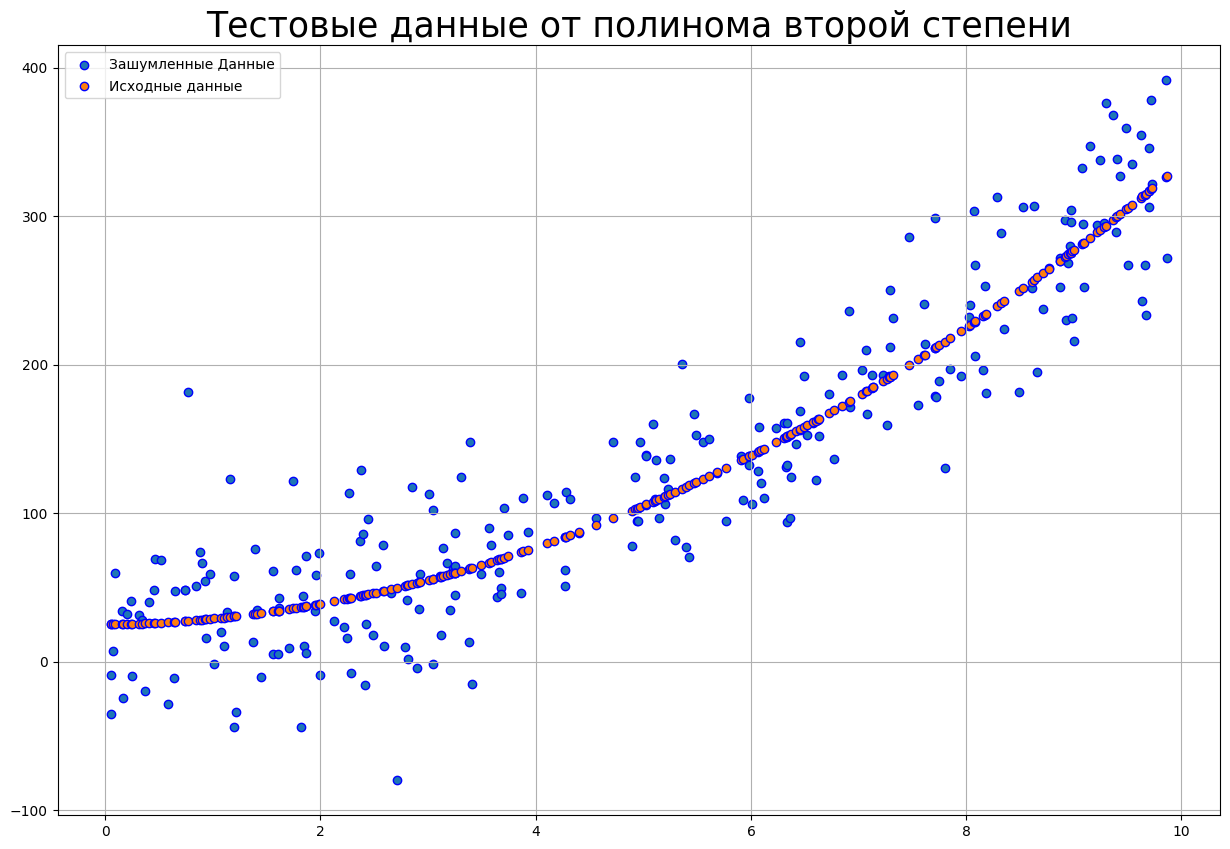

In [185]:
def vis_dataset(y, y_true, x, title):
    fig, ax = plt.subplots(figsize=(15,10))
    ax.scatter(x[:, 0], y, edgecolor='b', label="Зашумленные Данные")
    ax.scatter(x[:, 0], y_true, edgecolor='b', label="Исходные данные")
    ax.grid()
    ax.legend()
    ax.set_title(title, fontsize=25)
    
second_order_polynom_dataset = make_dataset([1, 3], b=25, x_max=10, noise_power=40)
vis_dataset(*second_order_polynom_dataset,
            title='Тестовые данные от полинома второй степени')

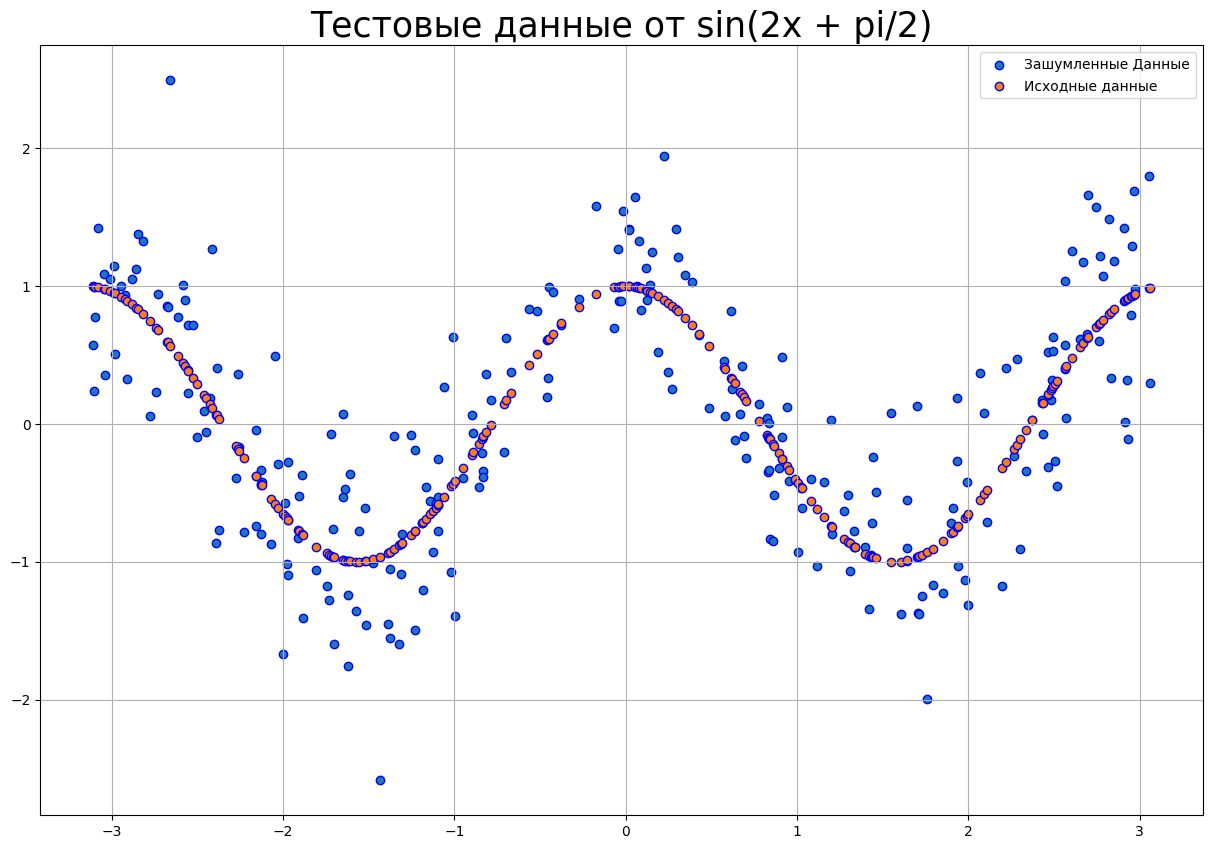

In [70]:
sin2x_withoffset_dataset = make_dataset(2, b=np.pi/2, fn=np.sin, x_max=np.pi*2, noise_power=0.5)

vis_dataset(*sin2x_withoffset_dataset,
            title='Тестовые данные от sin(2x + pi/2)')

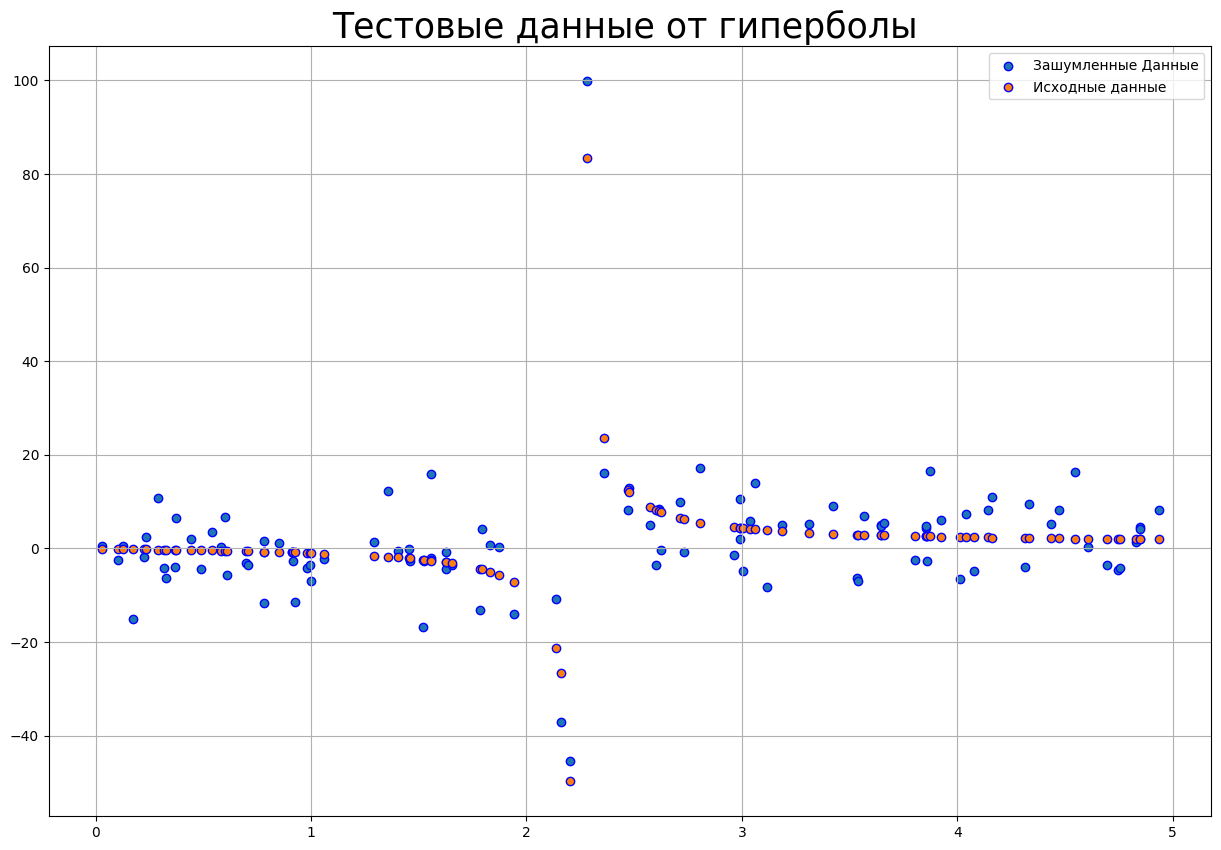

In [126]:
x_max = 5
def hyperbola(x):
    return x/(x - x_max/2)
hyperbola_dataset = make_dataset(weights=1, b=0.25, fn=hyperbola, noise_power=7.5, x_max=x_max, N=100)
vis_dataset(*hyperbola_dataset,
            title='Тестовые данные от гиперболы ')

### Тут копипаста

In [207]:
def split_train_test(x, y, train_size=None, test_size=None, random_state=42, shuffle=True):
    """Split test and train data"""
    
    if random_state:
        np.random.seed(random_state)
        
    size = y.shape[0]
    idxs = np.arange(size)
    if shuffle:
        np.random.shuffle(idxs)
    
    if test_size and train_size is None:
        if (test_size<=1): 
            train_size = 1 - test_size
        else:
            train_size = size - test_size
        test_size = None
    
    if train_size is None or train_size > size:
        train_size = size
        
    if train_size <= 1: 
        train_size *= size
    
    if test_size is not None: 
        if test_size<= 1:
            test_size *= size
        if test_size>size:
            test_size = size-train_size
    else: 
        test_size = 0
    
    x_train, y_train = x[idxs[:int(train_size)]], y[idxs[:int(train_size)]]
    x_val,   y_val   = x[idxs[int(train_size):size - int(test_size)]], y[idxs[int(train_size):size - int(test_size)]]
    
    if test_size > 0:
        x_test, y_test = x[idxs[size - int(test_size):]], y[idxs[size - int(test_size):]]
        return x_train, y_train.squeeze(), x_val, y_val.squeeze(), x_test, y_test.squeeze() 
    
    return x_train, y_train.squeeze(), x_val, y_val.squeeze()

x_train, y_train,  x_test, y_test = split_train_test(second_order_polynom_dataset[0],
                                                     second_order_polynom_dataset[1],  
                                                     test_size=0.3)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((175, 1), (175,), (75, 1), (75,))

In [261]:
def init_weights(W_shape, add_bias=True, random_state=42):
    W_shape = np.atleast_1d(W_shape)
    if random_state: 
        np.random.seed(random_state)
    W = np.random.randn(*list(W_shape))/np.sqrt(np.sum(W_shape))    
    
    if add_bias: 
        W = np.column_stack((np.zeros(W.shape[-1]),W ))
    return W.squeeze()

In [435]:
def predict(X, W, add_bias=True):
    X = X.copy()
    if add_bias:
        X = np.column_stack((np.ones(X.shape[0]), X))

    return np.dot(X, W)

def loss_fn(yhat, y):
    return (yhat - y) ** 2

def grad_loss(y_hat, y, X, add_bias=True):
    if add_bias:
        X_full = np.column_stack((np.ones(X.shape[0]), X))
    else:
        X_full = X
    
    return 2*np.dot(X_full.T, (y_hat - y)) / y.size  

In [436]:
y_, _, x_ = second_order_polynom_dataset

weights = init_weights(x_.shape[1])
yhat = predict(x_train[0], weights)
loss = loss_fn(yhat, y_[0])

In [437]:
def update_weights(grad, W, learning_rate):
    return W - learning_rate*grad

In [438]:
def fit(X, y, learning_rate, epsilon=0.01, epochs=None):
    weights = np.array([init_weights(X.shape[1])])
    epochs_ = epochs or 0
    
    while True:
        yhat = predict(X, weights[-1])
        dy = grad_loss(yhat, y, X)
        weights = np.row_stack((weights, update_weights(dy, weights[-1], learning_rate)))
        
        epochs_ -= 1
        
        if np.abs(dy)[0] < epsilon:
            print('epochs: ', -epochs_)
            return weights[-1], -epochs_
        elif epochs_ == 0:
            print('epochs: ', epochs)
            return weights[-1], dy, epochs

### Проверяем данные

In [439]:
def plot_model_weights(x_train, y_train, x_test, x, y, weights):
    plt.figure(figsize=(15, 10))
    plt.plot(x_train[:,0], 
             predict(x_train, weights),
            '.', 
            label='Предсказание на x_train',
            markersize = 12)
    plt.plot(x_test[:,0], 
             predict(x_test,weights),
            'o', 
            label='Предсказание на x_test',
            markersize = 12, 
            alpha =0.8)
    plt.plot(x_train[:,0], 
             y_train, '.',
            label="Тренировочные данные", linewidth=2,c='r')
    plt.plot(x[:,0], y, '--',
            label="Истинные Значения", linewidth=4,c='g')
    plt.grid()
    plt.legend(fontsize=16)
    plt.xlabel('x',fontsize=14)
    plt.ylabel('y',fontsize=14);

epochs:  1341


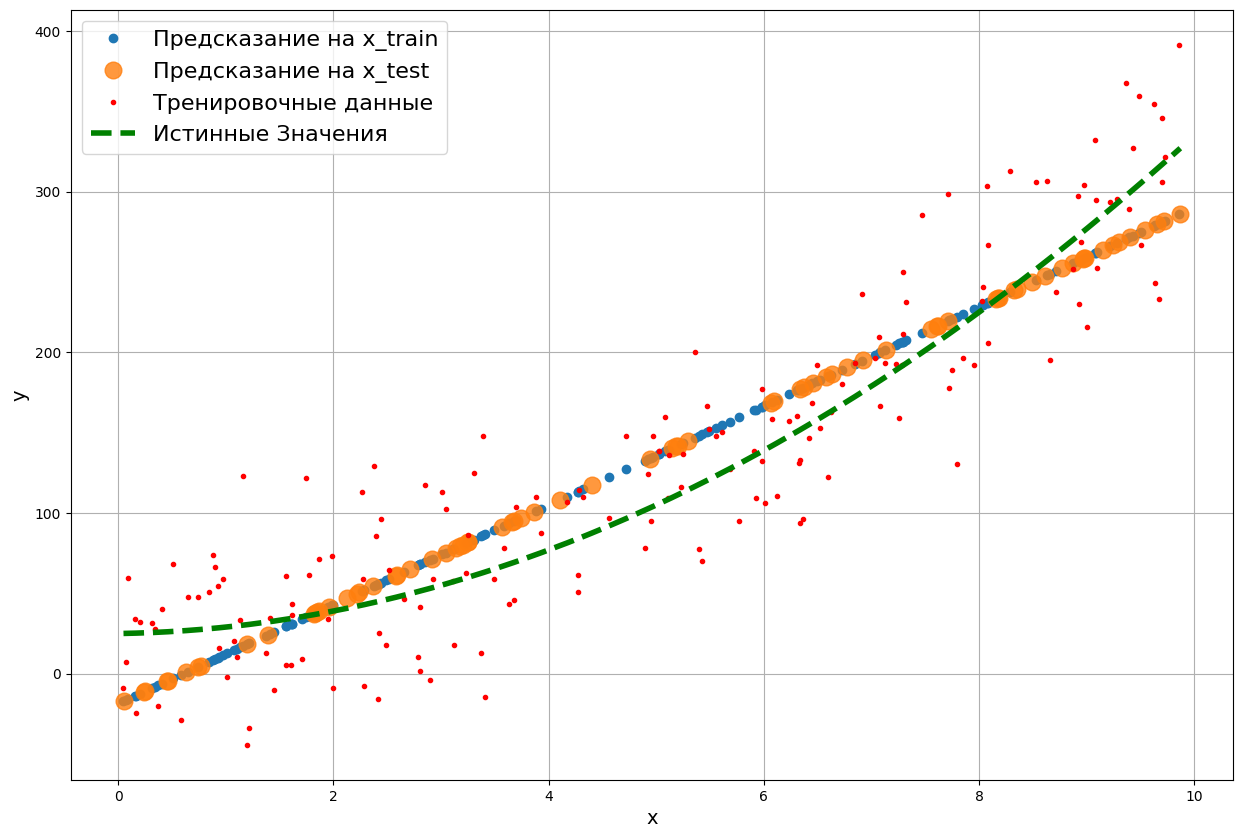

In [440]:
y_, y_true_, x_ = second_order_polynom_dataset
x_train, y_train, x_test, y_test = split_train_test(x_, y_, test_size=0.3)
weights, _ = fit(x_train, y_train, learning_rate=0.01, epochs=None)

plot_model_weights(x_train, y_train, x_test, x_, y_true_, weights)

### В целом подхватили тренд

epochs:  102


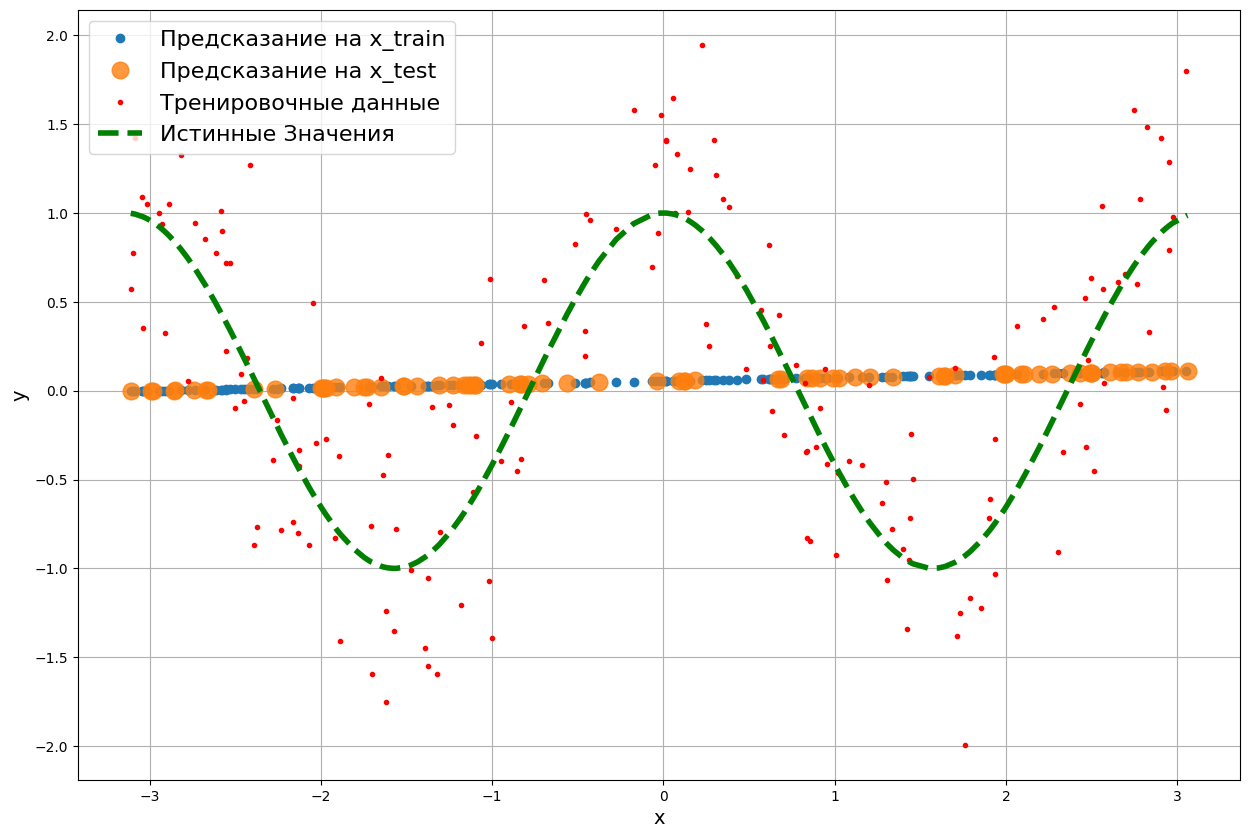

In [441]:
y_, y_true_, x_ = sin2x_withoffset_dataset
x_train, y_train, x_test, y_test = split_train_test(x_, y_, test_size=0.3)
weights, _ = fit(x_train, y_train, learning_rate=0.01, epochs=None)

plot_model_weights(x_train, y_train, x_test, x_, y_true_, weights)

### Линейная функция не сможет такое переварить

epochs:  917


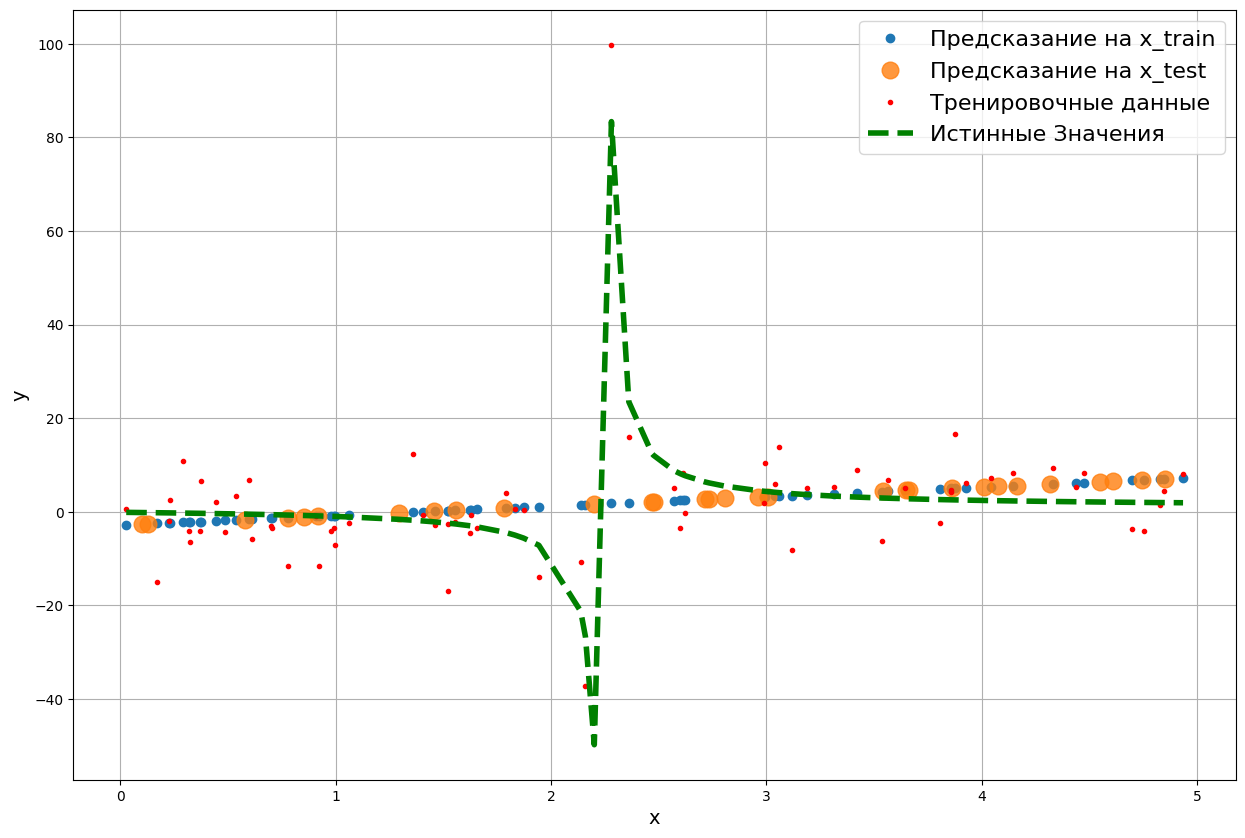

In [442]:
y_, y_true_, x_ = hyperbola_dataset
x_train, y_train, x_test, y_test = split_train_test(x_, y_, test_size=0.3)
weights, _ = fit(x_train, y_train, learning_rate=0.01, epochs=None)

plot_model_weights(x_train, y_train, x_test, x_, y_true_, weights)

### Здесь линейная функция в целом неплоха, но из-за смещения есть восходящий тренд, 
### а по идее аппроксимация должна быть около 0 по ординате